On commence par importer tout ce qui nous sera utile pour la suite 

In [10]:
import numpy as np
from itertools import permutations
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from urllib.request import urlopen
import warnings
import os

Cette cellule permet simplement de supprimer les warnings inutiles

In [11]:
warnings.filterwarnings('ignore')
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

On charge les dataset depuis les archives d'UCI via leurs url, attention le chargement nécéssite donc une connexion internet

In [12]:
def load_soybean():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-large.data"
    data = []
    for line in urlopen(url):
        line = line.decode("utf-8").strip()
        if line:
            data.append(line.split(","))
    
    df = pd.DataFrame(data)
    X = df.iloc[:, :-1].copy()  
    y = df.iloc[:, -1].copy()
    
    for col in X.columns:
        le = LabelEncoder()
        X.loc[:, col] = le.fit_transform(X[col])  
    
    y = LabelEncoder().fit_transform(y)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.astype(float))
    
    return X, y

def load_bsw():
    data = load_breast_cancer()
    X = StandardScaler().fit_transform(data.data)
    return X, data.target

def load_cancer():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
    data = []
    for line in urlopen(url):
        line = line.decode("utf-8").strip()
        if line:
            data.append(line.split(","))
    
    df = pd.DataFrame(data).replace('?', np.nan).dropna()
    X = df.iloc[:, 1:-1].astype(float).values
    y = LabelEncoder().fit_transform(df.iloc[:, -1].values)
    X = StandardScaler().fit_transform(X)
    
    return X, y

def load_seed():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
    data = []
    for line in urlopen(url):
        line = line.decode("utf-8").strip()
        if line:
            data.append(line.split())
    
    df = pd.DataFrame(data)
    X = df.iloc[:, :-1].astype(float).values
    y = df.iloc[:, -1].astype(int).values - 1
    X = StandardScaler().fit_transform(X)
    
    return X, y

def load_glass():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
    data = []
    for line in urlopen(url):
        line = line.decode("utf-8").strip()
        if line:
            data.append(line.split(","))
    
    df = pd.DataFrame(data)
    X = df.iloc[:, 1:-1].astype(float).values
    y = LabelEncoder().fit_transform(df.iloc[:, -1].values)
    X = StandardScaler().fit_transform(X)
    
    return X, y

def load_cmc():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data"
    data = []
    for line in urlopen(url):
        line = line.decode("utf-8").strip()
        if line:
            data.append(line.split(","))
    
    df = pd.DataFrame(data)
    X = df.iloc[:, :-1].astype(float).values
    y = df.iloc[:, -1].astype(int).values - 1
    X = StandardScaler().fit_transform(X)
    
    return X, y

def load_wine_4d():
    wine = load_wine()
    X = StandardScaler().fit_transform(wine.data[:, :4])
    return X, wine.target

# Ici on reproduit les jeux de données artificiels en restant fidèle aux caractérisitiques de ces derniers données par les auteurs dans l'article
# puisque les vrais jeux de données artificiels utilisés par les auteurs n'on pas été donnés et ne sont disponible nulle part.
def load_artset1():
    np.random.seed(42)
    n = 33
    c1 = np.random.randn(n, 2) * 0.5 + [0, 0]
    c2 = np.random.randn(n, 2) * 0.5 + [3, 3]
    c3 = np.random.randn(34, 2) * 0.5 + [6, 0]
    X = np.vstack([c1, c2, c3])
    y = np.array([0]*n + [1]*n + [2]*34)
    return X, y

def load_artset2():
    X = np.array([
        [1, 2, 3, 4, 5, 6, 7],
        [2, 3, 4, 5, 6, 7, 8],
        [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
        [10, 11, 12, 13, 14, 15, 16],
        [11, 12, 13, 14, 15, 16, 17],
        [20, 21, 22, 23, 24, 25, 26],
        [21, 22, 23, 24, 25, 26, 27]
    ])
    y = np.array([0, 0, 0, 1, 1, 2, 2])
    X = StandardScaler().fit_transform(X)
    return X, y

def load_artset3():
    np.random.seed(123)
    c1 = np.random.randn(8, 2) * 0.3 + [1, 1]
    c2 = np.random.randn(7, 2) * 0.3 + [4, 4]
    X = np.vstack([c1, c2])
    y = np.array([0]*8 + [1]*7)
    return X, y

Ici on défini des fonctions permettant de calculer les deux principales métriques de perfomances introduites dans l'article, à savoir l'accuracy et l'ICD (inter cluster distance). 

In [13]:
# --------------------------------------------------------
# Fonction : clustering_accuracy
# --------------------------------------------------------
# Évalue la précision d’un clustering en comparant les étiquettes 
# prédites à celles réelles, en trouvant la meilleure permutation 
# possible entre classes (pour gérer les labels arbitraires).
def clustering_accuracy(y_true, y_pred):
    """
    Calcule la précision du clustering après alignement optimal des classes.
    
    Args:
        y_true (array-like): vraies étiquettes.
        y_pred (array-like): étiquettes prédites par le clustering.
    
    Returns:
        float: taux de bonne classification (entre 0 et 1).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n_classes = len(np.unique(y_true))
    
    # Matrice de confusion entre vraies et prédites
    cm = confusion_matrix(y_true, y_pred)
    
    best = 0
    # On teste toutes les permutations possibles des labels
    for perm in permutations(range(n_classes)):
        correct = sum(cm[k, perm[k]] for k in range(n_classes))
        best = max(best, correct)
    
    # Meilleure correspondance normalisée
    return best / len(y_true)



# --------------------------------------------------------
# Fonction : inter_cluster_distance
# --------------------------------------------------------
# Calcule la plus petite distance entre les centres des clusters.
# Permet d’évaluer la séparation entre groupes obtenus.
def inter_cluster_distance(X, labels):
    """
    Calcule la plus petite distance entre centres de clusters.
    
    Args:
        X (ndarray): données de forme (n_samples, n_features).
        labels (array-like): étiquettes de cluster.
    
    Returns:
        float: distance minimale entre centres (0 si un seul cluster).
    """
    X = np.asarray(X)
    labels = np.asarray(labels)
    centers = []
    
    # Calcul des centres de chaque cluster
    for k in np.unique(labels):
        points_k = X[labels == k]
        if points_k.shape[0] > 0:
            centers.append(points_k.mean(axis=0))
    
    # Si moins de 2 centres, pas de distance à mesurer
    if len(centers) < 2:
        return 0.0
    
    centers = np.vstack(centers)
    dists = []
    
    # Distances euclidiennes entre tous les couples de centres
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dists.append(np.linalg.norm(centers[i] - centers[j]))
    
    # On renvoie la plus petite distance inter-centres
    return float(np.min(dists))

Passons à présent à l'implémentation de l'algorithme de FCM classique

In [14]:
# --------------------------------------------------------
# Fonction : initialize_memberships
# --------------------------------------------------------
# Initialise aléatoirement la matrice d'appartenance U (μ_ki) 
# en s’assurant que la somme des appartenances par point vaut 1.
def initialize_memberships(n_samples, n_clusters, random_state=None):
    """
    Initialise les appartenances aléatoires des points aux clusters.
    
    Args:
        n_samples (int): nombre d’échantillons.
        n_clusters (int): nombre de clusters.
        random_state (int, optional): graine aléatoire.
    
    Returns:
        ndarray: matrice U de forme (n_clusters, n_samples),
                 où chaque colonne somme à 1.
    """
    rng = np.random.default_rng(random_state)
    U = rng.random((n_clusters, n_samples))          # tirages aléatoires
    U /= U.sum(axis=0, keepdims=True)               # normalisation par colonne
    return U


# --------------------------------------------------------
# Fonction : fcm_update_centers
# --------------------------------------------------------
# Met à jour les centres des clusters selon la règle FCM classique :
#   C_k = (Σ_i (μ_ki)^m * x_i) / (Σ_i (μ_ki)^m)
# Une version pondérée optionnelle est prévue si une matrice de distance est fournie.
def fcm_update_centers(X, U, m, dist_matrix=None):
    """
    Met à jour les centres de clusters selon la règle FCM.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        U (ndarray): appartenances (n_clusters, n_samples).
        m (float): coefficient de flou (>1).
        dist_matrix (ndarray, optional): pondérations supplémentaires.
    
    Returns:
        ndarray: nouveaux centres C de forme (n_clusters, n_features).
    """
    um = U ** m  # pondération floue
    if dist_matrix is None:
        return (um @ X) / um.sum(axis=1, keepdims=True)
    else:
        w = um * dist_matrix
        return (w @ X) / w.sum(axis=1, keepdims=True)


# --------------------------------------------------------
# Fonction : fcm_update_memberships_from_dist
# --------------------------------------------------------
# Met à jour la matrice d'appartenance U à partir des distances 
# entre points et centres (formule FCM standard).
def fcm_update_memberships_from_dist(dist, m):
    """
    Met à jour les appartenances μ_ki selon les distances d_ki.
    
    Args:
        dist (ndarray): distances (n_clusters, n_samples).
        m (float): coefficient de flou (>1).
    
    Returns:
        ndarray: nouvelle matrice d'appartenance (n_clusters, n_samples).
    """
    dist = np.maximum(dist, 1e-10)                  # éviter les divisions par zéro
    power = 2.0 / (m - 1)
    ratio = (dist[:, None, :] / dist[None, :, :]) ** power  # rapport des distances
    return 1.0 / ratio.sum(axis=1)                  # normalisation


# --------------------------------------------------------
# Fonction : fcm_classic
# --------------------------------------------------------
# Implémentation complète de l’algorithme FCM :
# 1. Initialisation des appartenances
# 2. Boucle de mise à jour des centres et des appartenances
# 3. Arrêt lorsque la variation de U est inférieure à tol
def fcm_classic(X, n_clusters, m=2.0, max_iter=150, tol=1e-5, random_state=None):
    """
    Algorithme Fuzzy C-Means standard.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        n_clusters (int): nombre de clusters.
        m (float): coefficient de flou.
        max_iter (int): nombre max d’itérations.
        tol (float): tolérance de convergence.
        random_state (int, optional): graine aléatoire.
    
    Returns:
        tuple: (C, U, labels)
            C (ndarray): centres des clusters.
            U (ndarray): appartenance floue.
            labels (ndarray): cluster dominant pour chaque point.
    """
    n_samples = X.shape[0]
    U = initialize_memberships(n_samples, n_clusters, random_state=random_state)
    
    for _ in range(max_iter):
        C = fcm_update_centers(X, U, m)                               # mise à jour des centres
        dist = np.linalg.norm(X[None, :, :] - C[:, None, :], axis=2)  # distances euclidiennes
        U_new = fcm_update_memberships_from_dist(dist, m)             # mise à jour des appartenances
        
        # Critère d'arrêt sur la variation de U
        if np.linalg.norm(U_new - U) < tol:
            U = U_new
            break
        U = U_new
    
    # Labels durs à partir des appartenances maximales
    return C, U, U.argmax(axis=0)


IFCM avec la nouvelle métrique d_new

In [15]:
# --------------------------------------------------------
# Fonction : compute_u_i
# --------------------------------------------------------
# Calcule le coefficient u_i pour chaque point selon Kumar (Eq.13) :
# u_i = sqrt(|mean(x_i) + 1|)
# Sert à pondérer la distance dans l'IFCM.
def compute_u_i(X):
    """
    Calcule le coefficient u_i pour chaque échantillon.
    
    Args:
        X (ndarray): données (n_samples, n_features).
    
    Returns:
        ndarray: valeurs u_i (n_samples,).
    """
    mean_per_point = X.mean(axis=1)              # moyenne de chaque vecteur
    return np.sqrt(np.abs(mean_per_point + 1.0)) # pondération positive


# --------------------------------------------------------
# Fonction : d_new_matrix
# --------------------------------------------------------
# Calcule la distance modifiée d_new entre chaque point x_i et centre C_k :
# d_new(x_i, C_k) = 1 - exp(-u_i * ||x_i - C_k||² / σ²)
# → distance bornée entre 0 et 1, rendant l'algorithme plus robuste aux outliers.
def d_new_matrix(X, C, u, sigma):
    """
    Calcule la matrice des distances d_new entre points et centres.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        C (ndarray): centres (n_clusters, n_features).
        u (ndarray): coefficients u_i (n_samples,).
        sigma (float): paramètre d’échelle.
    
    Returns:
        ndarray: distances d_new (n_clusters, n_samples).
    """
    diff = X[None, :, :] - C[:, None, :]          # différences C_k - x_i
    sq_norm = np.sum(diff ** 2, axis=2)           # norme euclidienne au carré
    u_matrix = u[None, :]                         # diffusion de u_i sur les lignes
    return 1.0 - np.exp(-u_matrix * sq_norm / (sigma ** 2))


# --------------------------------------------------------
# Fonction : ifcm
# --------------------------------------------------------
# Implémentation de l’algorithme IFCM (Improved Fuzzy C-Means) :
# - calcule sigma si non fourni
# - pondère les distances avec u_i 
def ifcm(X, n_clusters, m=2.0, max_iter=150, tol=1e-5, sigma=None, random_state=None):
    """
    Algorithme Improved Fuzzy C-Means (IFCM).
    
    Args:
        X (ndarray): données (n_samples, n_features).
        n_clusters (int): nombre de clusters.
        m (float): coefficient de flou.
        max_iter (int): nombre max d’itérations.
        tol (float): tolérance de convergence.
        sigma (float, optional): paramètre de distance. Calculé automatiquement si None.
        random_state (int, optional): graine aléatoire.
    
    Returns:
        tuple: (C, U, labels)
            C (ndarray): centres des clusters.
            U (ndarray): appartenance floue.
            labels (ndarray): cluster dominant pour chaque point.
    """
    n_samples, d = X.shape
    
    # Si sigma non fourni, on le calcule comme la moyenne des distances moyennes
    if sigma is None:
        from sklearn.metrics import pairwise_distances
        sigma = np.mean(pairwise_distances(X))
    
    # Coefficients u_i et initialisation de U
    u = compute_u_i(X)
    U = initialize_memberships(n_samples, n_clusters, random_state=random_state)
    
    # Boucle principale : mise à jour des centres et appartenances
    for _ in range(max_iter):
        C = fcm_update_centers(X, U, m)                               # centres initiaux
        diff = X[None, :, :] - C[:, None, :]                          # distances
        sq_norm = np.sum(diff**2, axis=2)
        W = np.exp(-u[None, :] * sq_norm / (sigma**2))                # pondération locale
        C = fcm_update_centers(X, U, m, dist_matrix=W)                # mise à jour pondérée
        D = d_new_matrix(X, C, u, sigma)                              # distances d_new
        U_new = fcm_update_memberships_from_dist(D, m)                # mise à jour de U
        
        # Condition de convergence
        if np.linalg.norm(U_new - U) < tol:
            U = U_new
            break
        U = U_new
    

    return C, U, U.argmax(axis=0)


On passe maintenant à l'implémentation de PSOIFCM ( initialisation des centroïdes via PSO et Improved Fuzzy clustering par la suite )

In [16]:
# --------------------------------------------------------
# Fonction : ifcm_objective
# --------------------------------------------------------
# Calcule la fonction objectif IFCM pour un jeu de centres C :
# - met à jour U à partir de la distance d_new
# - retourne J = Σ_k Σ_i (μ_ki^m) * d_new(x_i, C_k) et la matrice U associée
def ifcm_objective(X, C, u, m, sigma):
    """
    Calcule l’objectif IFCM et la matrice d'appartenance correspondante.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        C (ndarray): centres (n_clusters, n_features).
        u (ndarray): coefficients u_i (n_samples,).
        m (float): coefficient de flou (>1).
        sigma (float): paramètre d’échelle de d_new.
    
    Returns:
        tuple: (J, U)
            J (float): valeur de l’objectif IFCM.
            U (ndarray): appartenances (n_clusters, n_samples).
    """
    D = d_new_matrix(X, C, u, sigma)              # distances d_new
    U = fcm_update_memberships_from_dist(D, m)    # appartenance optimale pour C
    J = np.sum((U**m) * D)                        # objectif
    return J, U


# --------------------------------------------------------
# Fonction : ifcm_with_init
# --------------------------------------------------------
# Version d’IFCM avec centres initiaux fournis (ou init heuristique par blocs).
# Alterne mise à jour des centres pondérés (W) et des appartenances (via d_new)
# jusqu’à convergence sur U.
def ifcm_with_init(X, n_clusters, m=2.0, max_iter=100, tol=1e-5,
                   sigma=None, C_init=None, random_state=None):
    """
    Exécute IFCM en partant de centres initiaux (C_init) si fournis.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        n_clusters (int): nombre de clusters.
        m (float): coefficient de flou.
        max_iter (int): itérations max.
        tol (float): seuil de convergence sur U.
        sigma (float, optional): paramètre d_new, estimé si None.
        C_init (ndarray, optional): centres initiaux (n_clusters, n_features).
        random_state (int, optional): graine aléatoire.
    
    Returns:
        tuple: (C, U, labels)
    """
    n_samples, d = X.shape
    rng = np.random.default_rng(random_state)
    
    # Estimation de sigma si absent
    if sigma is None:
        from sklearn.metrics import pairwise_distances
        sigma = np.mean(pairwise_distances(X))
    
    u = compute_u_i(X)  # coefficients locaux
    
    # Initialisation des centres : C_init sinon moyenne par blocs
    if C_init is None:
        H = n_samples // n_clusters
        C = []
        for k in range(n_clusters):
            start_idx = k * H
            end_idx = start_idx + H if k < n_clusters - 1 else n_samples
            C.append(X[start_idx:end_idx].mean(axis=0))
        C = np.array(C)
    else:
        C = C_init.copy()
    
    # Initialisation des appartenances U (aléatoire normalisée par colonne)
    U = rng.random((n_clusters, n_samples))
    U /= U.sum(axis=0, keepdims=True)
    
    for iteration in range(max_iter):
        # Pondération locale W
        diff = X[None, :, :] - C[:, None, :]
        sq_norm = np.sum(diff**2, axis=2)
        W = np.exp(-u[None, :] * sq_norm / (sigma**2))
        
        # Mise à jour des centres pondérés
        um = U**m
        C_new = ((um * W) @ X) / (um * W).sum(axis=1, keepdims=True)
        
        # Mise à jour des appartenances via d_new
        D = d_new_matrix(X, C_new, u, sigma)
        U_new = fcm_update_memberships_from_dist(D, m)
        
        # Convergence sur U
        if np.linalg.norm(U_new - U) < tol:
            C, U = C_new, U_new
            break
        
        C, U = C_new, U_new
    
    return C, U, U.argmax(axis=0)


# --------------------------------------------------------
# Fonction : pso_ifcm_centers
# --------------------------------------------------------
# PSO pour rechercher de bons centres initiaux pour IFCM.
# - Particules = ensembles de centres
# - Fitness = 1 / (J + ε),
# - Critère d’arrêt : stabilité de fitness (ff < ff_threshold)
def pso_ifcm_centers(
    X, n_clusters, m=2.0, n_particles=20, max_iter=50,
    w=0.9, c1=1.49, c2=1.49, sigma=None, random_state=None,
    ff_threshold=1e-5, eta1=0.5949, eta2=0.0855
):
    """
    Utilise PSO pour optimiser des centres initiaux destinés à IFCM.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        n_clusters (int): nombre de clusters.
        m (float): coefficient de flou pour l’objectif IFCM.
        n_particles (int): taille de l’essaim.
        max_iter (int): itérations PSO.
        w (float): inertie.
        c1 (float): poids cognitif (vers pbest).
        c2 (float): poids social (vers gbest).
        sigma (float, optional): paramètre d_new (estimé si None).
        random_state (int, optional): graine.
        ff_threshold (float): seuil sur la stabilité des fitness.
        eta1 (float): facteur r1 (ici constant).
        eta2 (float): facteur r2 (ici constant).
    
    Returns:
        tuple: (gbest_pos, gbest_fit)
            gbest_pos (ndarray): meilleurs centres trouvés.
            gbest_fit (float): fitness associée.
    """
    rng = np.random.default_rng(random_state)
    n_samples, d = X.shape

    # Estimation de sigma si absent
    if sigma is None:
        from sklearn.metrics import pairwise_distances
        sigma = np.mean(pairwise_distances(X))

    u = compute_u_i(X)
    xi = 1e-6  # epsilon de stabilité pour la fitness

    # ---------------------- Initialisation des particules ----------------------
    particles = []
    H = n_samples // n_clusters
    for _ in range(n_particles):
        perm_idx = rng.permutation(n_samples)    # permutation pour diversifier
        particle_centers = []
        for k in range(n_clusters):
            start_idx = k * H
            end_idx = start_idx + H if k < n_clusters - 1 else n_samples
            cluster_points = X[perm_idx[start_idx:end_idx]]
            particle_centers.append(cluster_points.mean(axis=0))  # centre par bloc
        particles.append(np.array(particle_centers))
    particles = np.stack(particles)

    # Vitesses et pbest
    velocities = rng.normal(scale=0.1, size=particles.shape)
    pbest_pos = particles.copy()
    pbest_fit = np.empty(n_particles)

    # Évaluation initiale
    for i in range(n_particles):
        J, _ = ifcm_objective(X, particles[i], u, m, sigma)
        pbest_fit[i] = 1.0 / (J + xi)

    # gbest initial
    gbest_index = np.argmax(pbest_fit)
    gbest_pos = pbest_pos[gbest_index].copy()
    gbest_fit = pbest_fit[gbest_index]

    # ------------------------------ Boucle PSO -------------------------------
    for it in range(max_iter):
        fits = []

        for i in range(n_particles):
            # r1, r2 constants (dans la version du papier)
            r1 = eta1
            r2 = eta2
            
            # Mise à jour vitesse et position
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest_pos[i] - particles[i])
                + c2 * r2 * (gbest_pos - particles[i])
            )
            particles[i] = particles[i] + velocities[i]

            # Évalue la fitness via l’objectif IFCM
            J, _ = ifcm_objective(X, particles[i], u, m, sigma)
            fit = 1.0 / (J + xi)
            fits.append(fit)

            # Mise à jour du pbest
            if fit > pbest_fit[i]:
                pbest_fit[i] = fit
                pbest_pos[i] = particles[i].copy()

        fits = np.asarray(fits, dtype=float)

        # Mise à jour du gbest
        max_fit_idx = np.argmax(fits)
        if fits[max_fit_idx] > gbest_fit:
            gbest_fit = fits[max_fit_idx]
            gbest_pos = particles[max_fit_idx].copy()

        # Mesure de stabilité des fitness (ff) et critère d'arrêt
        f_avg = np.mean(fits)
        safe_f = np.where(fits == 0.0, 1e-12, fits)
        ff = np.max(((safe_f - f_avg) / safe_f) ** 2)
        if ff < ff_threshold:
            break
            
    return gbest_pos, gbest_fit



# --------------------------------------------------------
# Fonction : pso_ifcm
# --------------------------------------------------------
# Pipeline complet : 
#  PSO pour centres initiaux
#  Affinage via IFCM en partant de ces centres
def pso_ifcm(X, n_clusters, m=2.0, n_particles=20, max_iter_pso=50,
             max_iter_ifcm=100, random_state=None, 
             w=0.9, c1=1.49, c2=1.49, eta1=0.5949, eta2=0.0855):
    """
    PSO-IFCM : initialisation par PSO, puis raffinement par IFCM.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        n_clusters (int): nombre de clusters.
        m (float): coefficient de flou pour IFCM.
        n_particles (int): taille de l’essaim PSO.
        max_iter_pso (int): itérations PSO.
        max_iter_ifcm (int): itérations IFCM.
        random_state (int, optional): graine.
        w, c1, c2, eta1, eta2: hyperparamètres PSO.
    
    Returns:
        tuple: (C, U, labels) issus d’IFCM final.
    """
    # 1) Cherche de bons centres avec PSO
    gbest_centers, _ = pso_ifcm_centers(
        X, n_clusters, m=m, n_particles=n_particles,
        max_iter=max_iter_pso, random_state=random_state,
        w=w, c1=c1, c2=c2, eta1=eta1, eta2=eta2
    )
    
    # 2) Lance IFCM en partant de ces centres
    C, U, labels = ifcm_with_init(
        X, n_clusters, m=m, max_iter=max_iter_ifcm,
        C_init=gbest_centers, random_state=random_state
    )
    
    return C, U, labels


Visualisation

In [17]:
# --------------------------------------------------------
# Fonction : plot_clusters_pca
# --------------------------------------------------------
# Visualise les résultats de différents algorithmes de clustering 
# après réduction en 2D par ACP (PCA). 
# Chaque sous-graphe correspond à un algorithme (labels_dict).
def plot_clusters_pca(X, labels_dict, title_prefix):
    """
    Affiche la projection PCA 2D des clusters issus de plusieurs algorithmes.
    
    Args:
        X (ndarray): données d'entrée (n_samples, n_features).
        labels_dict (dict): dictionnaire {nom_algo: labels_prédits}.
        title_prefix (str): titre principal pour la figure.
    
    Returns:
        None: affiche directement les graphiques.
    """
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)                  # projection des données en 2D
    
    n_algos = len(labels_dict)
    fig, axes = plt.subplots(1, n_algos, figsize=(4 * n_algos, 4))
    
    if n_algos == 1:
        axes = [axes]                            # gestion du cas 1 seul graphique
    
    # Affichage de chaque clustering dans un sous-graphique
    for ax, (name, labels) in zip(axes, labels_dict.items()):
        ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", s=25)
        ax.set_title(name)
        ax.set_xticks([])                        # suppression des axes pour clarté
        ax.set_yticks([])
    
    fig.suptitle(title_prefix, fontsize=14)
    plt.tight_layout()
    plt.show()


Expérimentations / reproductions partielles 


Dataset: Iris (n=150, d=4, c=3)
KMeans                    | Acc = 0.893 | ICD = 1.797
Agglo Ward                | Acc = 0.893 | ICD = 1.812
FCM                       | Acc = 0.893 | ICD = 1.779
IFCM                      | Acc = 0.913 | ICD = 1.738
PSOIFCM                   | Acc = 0.907 | ICD = 1.734


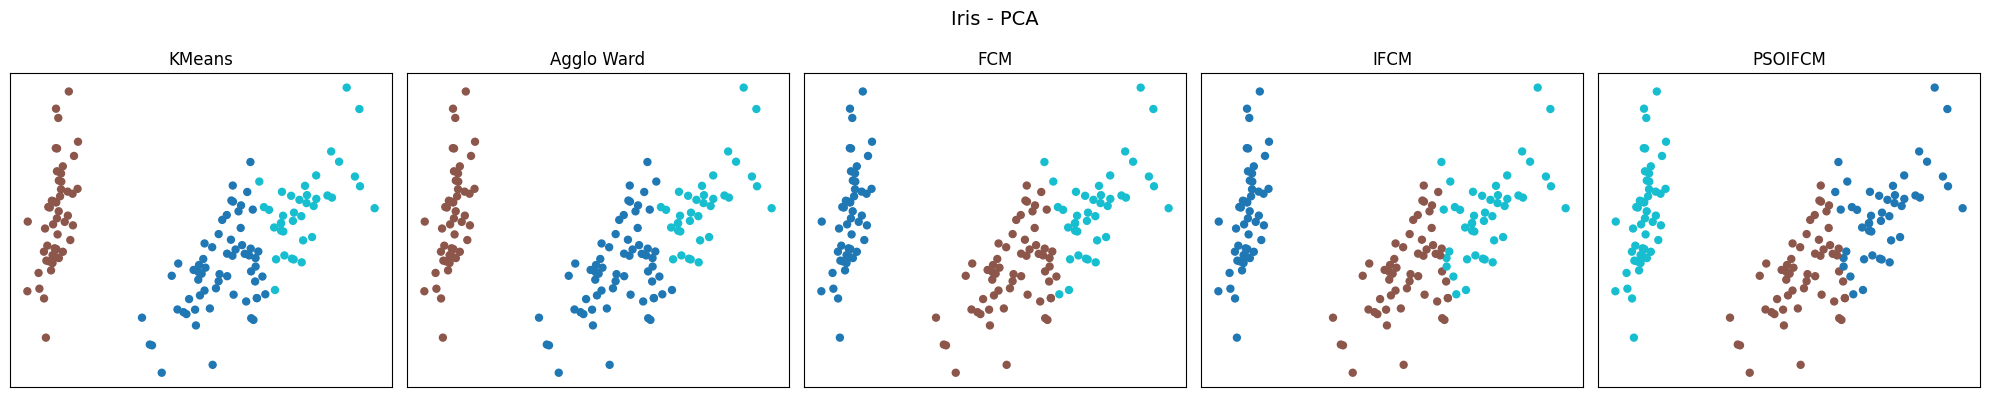


Dataset: Wine (n=178, d=13, c=3)
KMeans                    | Acc = 0.702 | ICD = 270.348
Agglo Ward                | Acc = 0.697 | ICD = 267.215
FCM                       | Acc = 0.685 | ICD = 274.524
IFCM                      | Acc = 0.713 | ICD = 230.973
PSOIFCM                   | Acc = 0.713 | ICD = 222.454


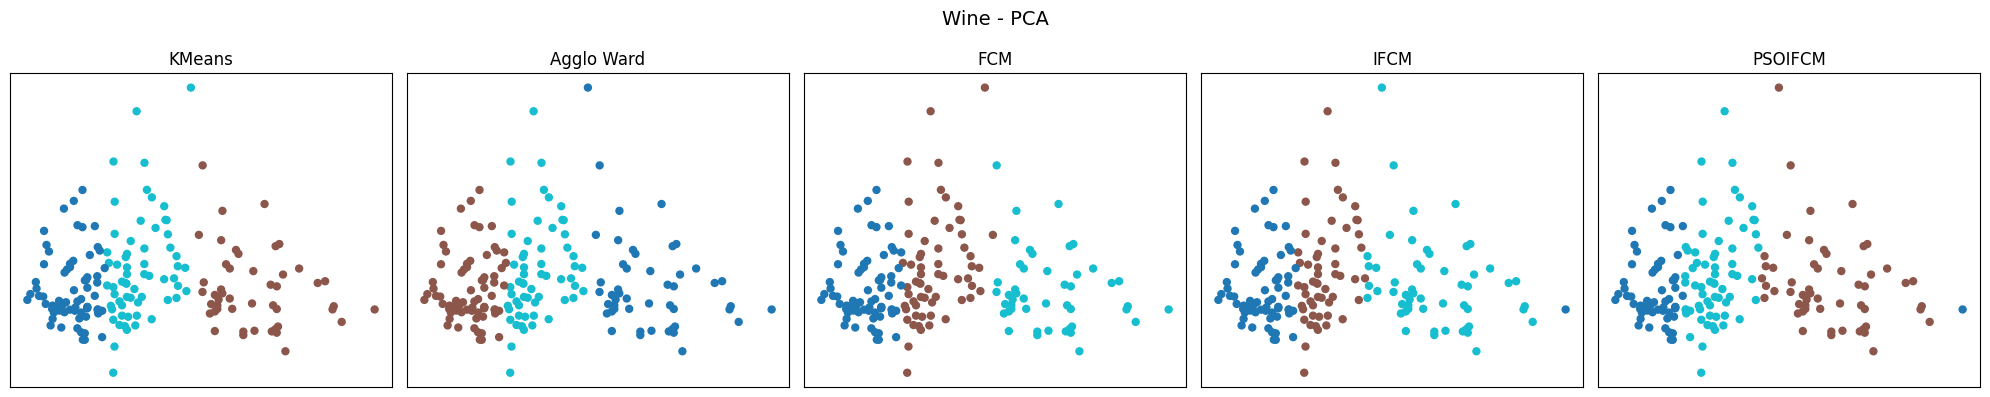


Dataset: BSW (n=569, d=30, c=2)
KMeans                    | Acc = 0.910 | ICD = 6.586
Agglo Ward                | Acc = 0.880 | ICD = 6.465
FCM                       | Acc = 0.914 | ICD = 6.499
IFCM                      | Acc = 0.928 | ICD = 6.350
PSOIFCM                   | Acc = 0.926 | ICD = 6.340


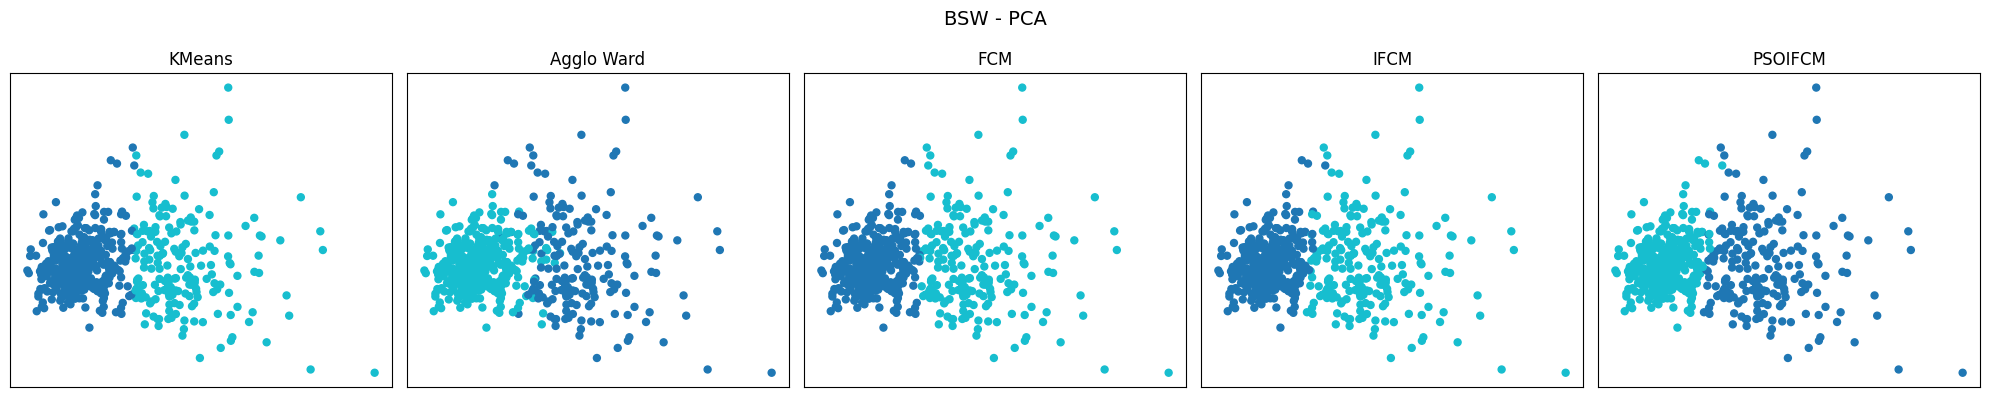


Dataset: Cancer (n=683, d=9, c=2)
KMeans                    | Acc = 0.958 | ICD = 4.734
Agglo Ward                | Acc = 0.968 | ICD = 4.653
FCM                       | Acc = 0.950 | ICD = 4.769
IFCM                      | Acc = 0.971 | ICD = 4.675
PSOIFCM                   | Acc = 0.972 | ICD = 4.672


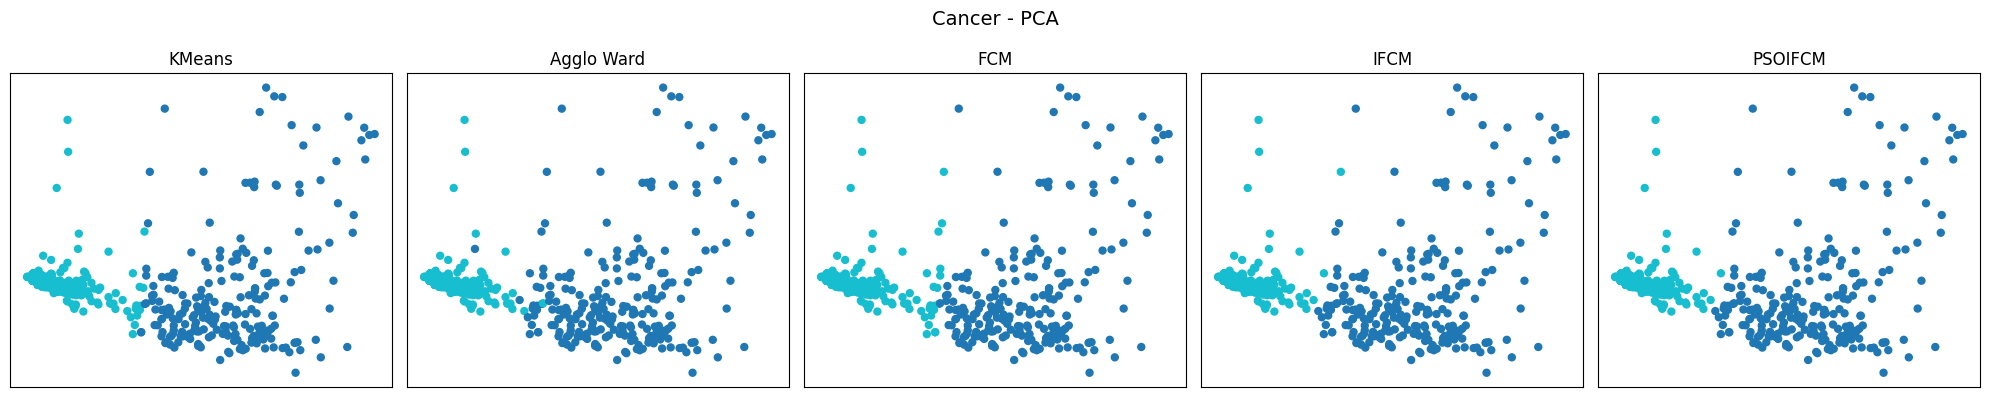


Dataset: Seed (n=210, d=7, c=3)
KMeans                    | Acc = 0.919 | ICD = 2.632
Agglo Ward                | Acc = 0.929 | ICD = 2.584
FCM                       | Acc = 0.919 | ICD = 2.627
IFCM                      | Acc = 0.924 | ICD = 2.639
PSOIFCM                   | Acc = 0.924 | ICD = 2.639


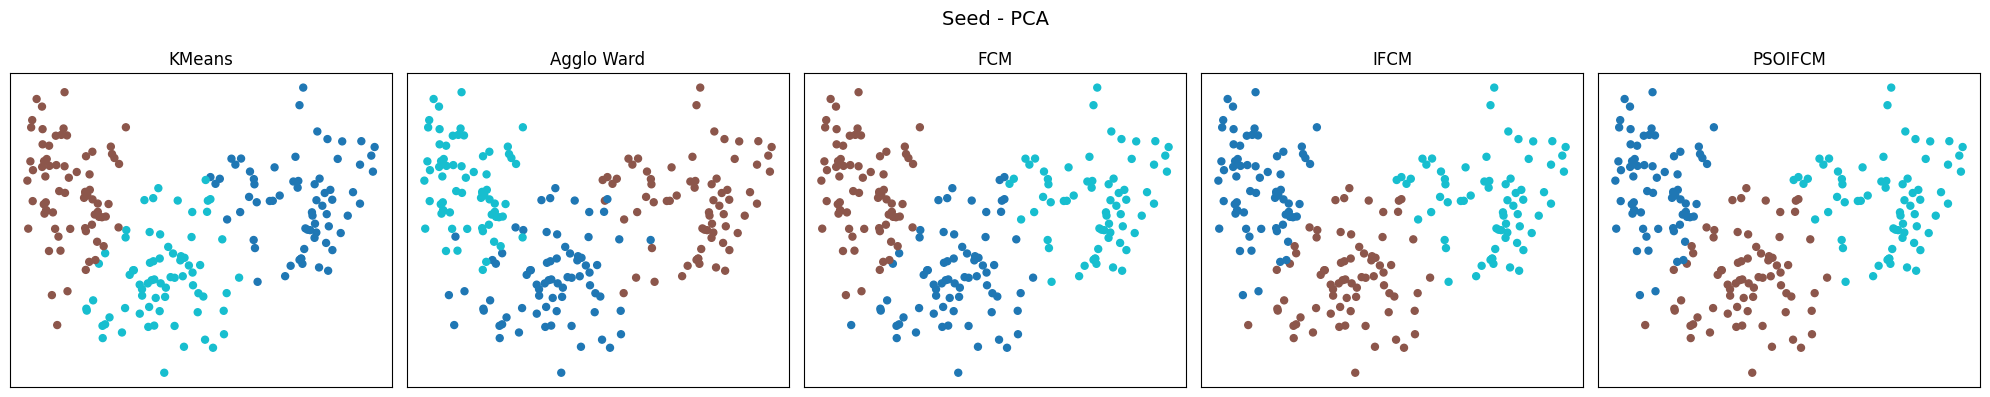


Dataset: Soybean (n=307, d=35, c=4)
KMeans                    | Acc = 0.687 | ICD = 4.301
Agglo Ward                | Acc = 0.577 | ICD = 3.844
FCM                       | Acc = 0.534 | ICD = 3.447
IFCM                      | Acc = 0.349 | ICD = 2.697
PSOIFCM                   | Acc = 0.342 | ICD = 2.402


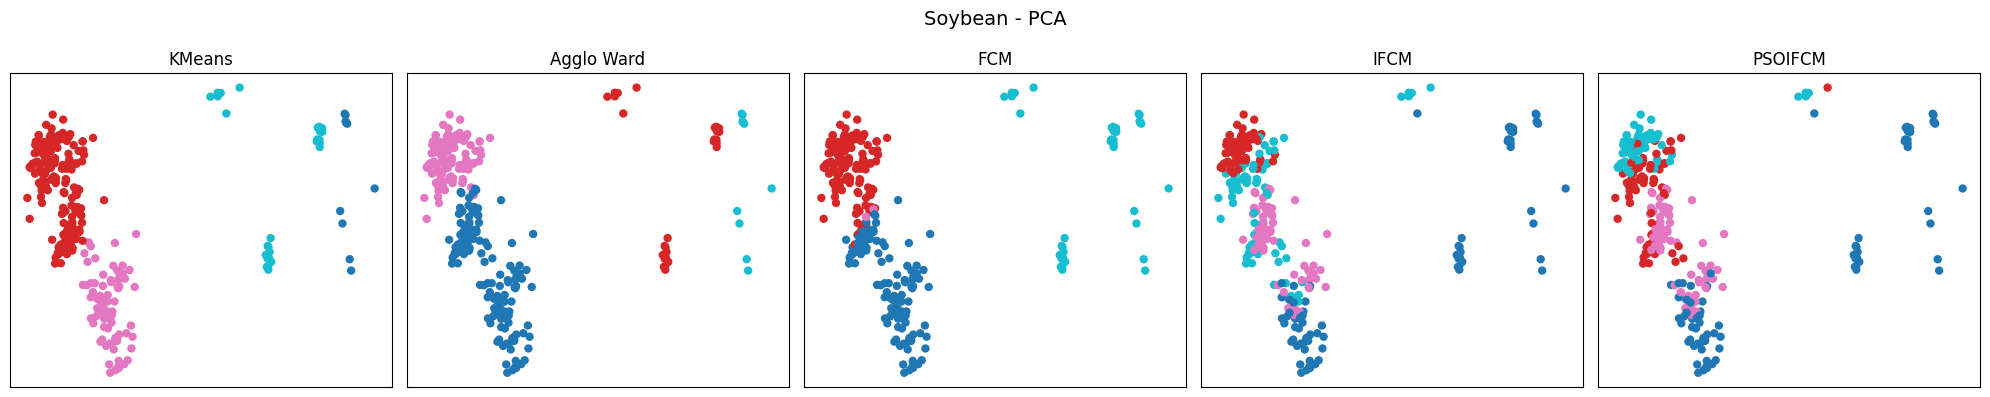


Dataset: Glass (n=214, d=9, c=6)
KMeans                    | Acc = 0.467 | ICD = 2.209
Agglo Ward                | Acc = 0.421 | ICD = 2.099
FCM                       | Acc = 0.407 | ICD = 1.191
IFCM                      | Acc = 0.407 | ICD = 1.336
PSOIFCM                   | Acc = 0.369 | ICD = 1.319


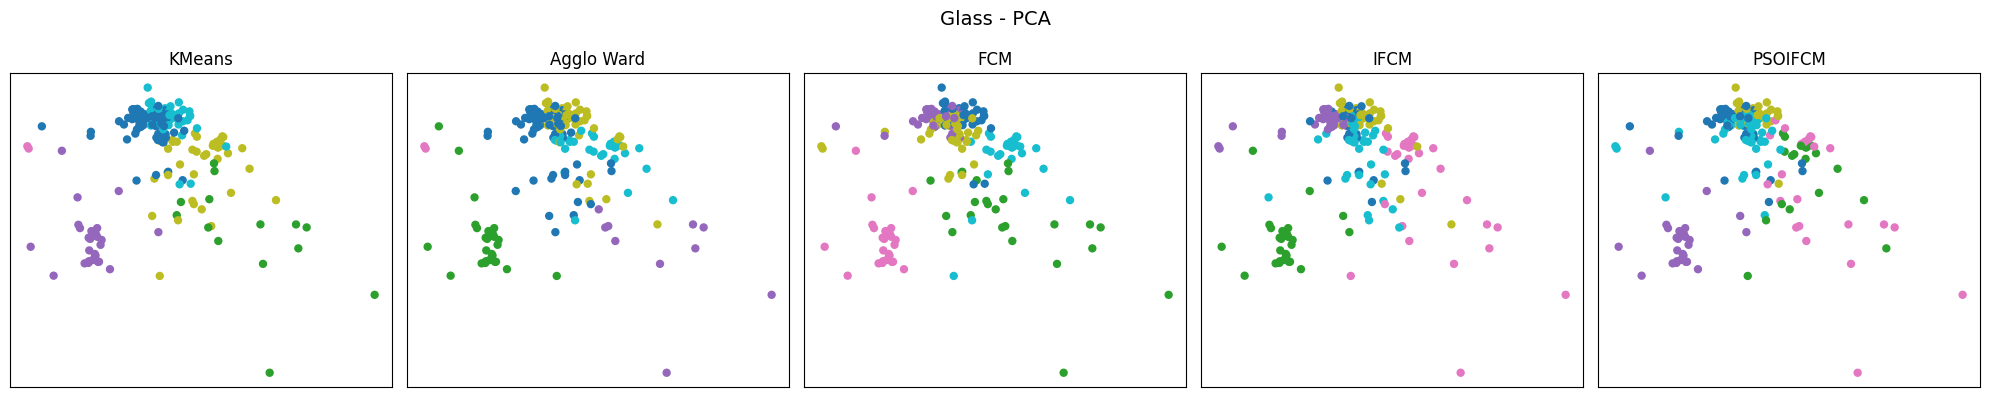


Dataset: CMC (n=1473, d=9, c=3)
KMeans                    | Acc = 0.394 | ICD = 2.488
Agglo Ward                | Acc = 0.396 | ICD = 2.993
FCM                       | Acc = 0.423 | ICD = 1.565
IFCM                      | Acc = 0.443 | ICD = 2.265
PSOIFCM                   | Acc = 0.440 | ICD = 2.226


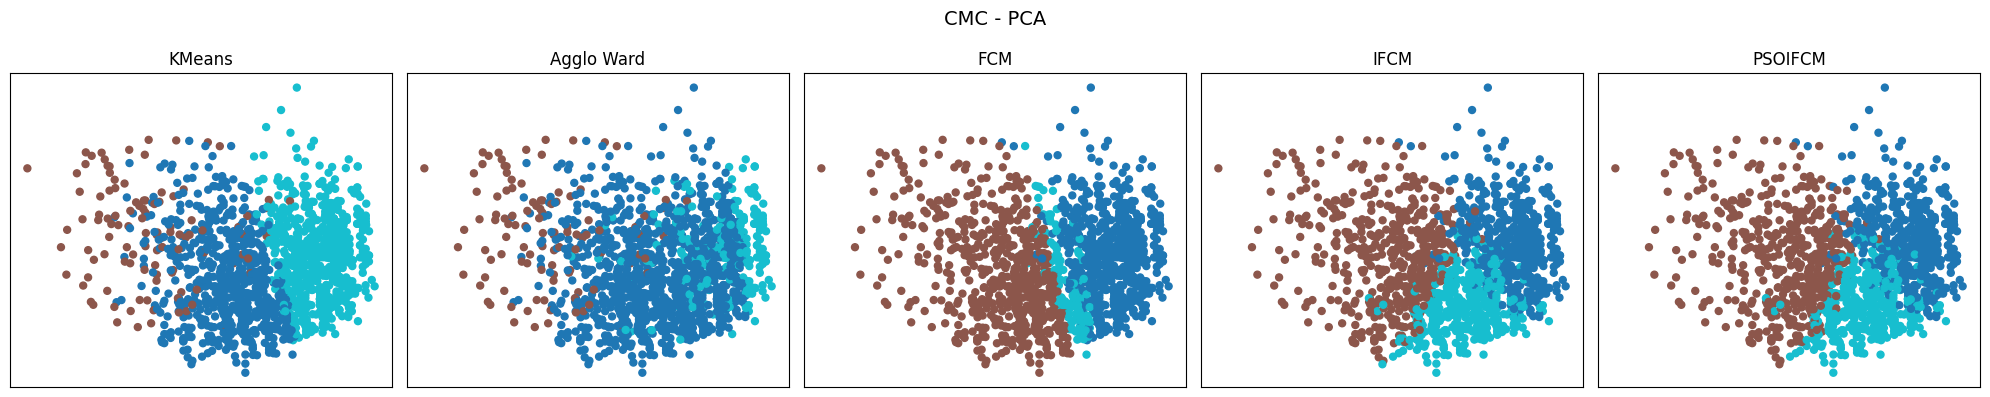


Dataset: Wine 4D (n=178, d=4, c=3)
KMeans                    | Acc = 0.826 | ICD = 2.288
Agglo Ward                | Acc = 0.787 | ICD = 2.236
FCM                       | Acc = 0.837 | ICD = 2.257
IFCM                      | Acc = 0.826 | ICD = 2.294
PSOIFCM                   | Acc = 0.826 | ICD = 2.294


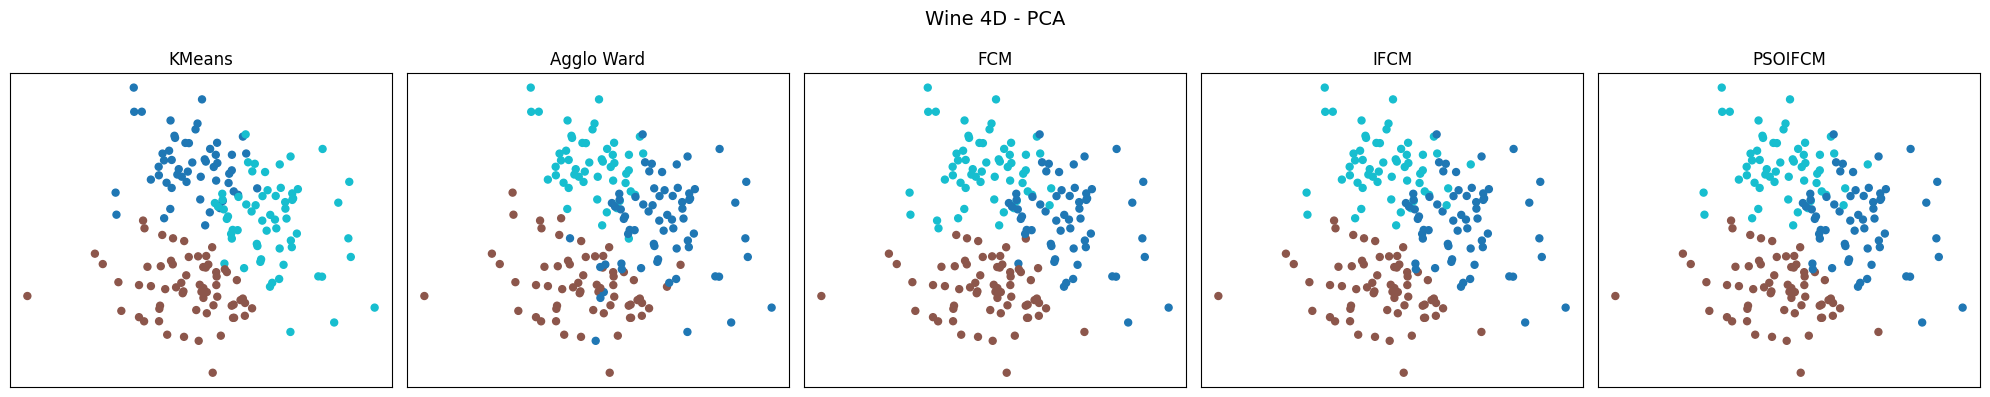


Dataset: ArtSet 1 (n=100, d=2, c=3)
KMeans                    | Acc = 1.000 | ICD = 4.171
Agglo Ward                | Acc = 1.000 | ICD = 4.171
FCM                       | Acc = 1.000 | ICD = 4.171
IFCM                      | Acc = 1.000 | ICD = 4.171
PSOIFCM                   | Acc = 1.000 | ICD = 4.171


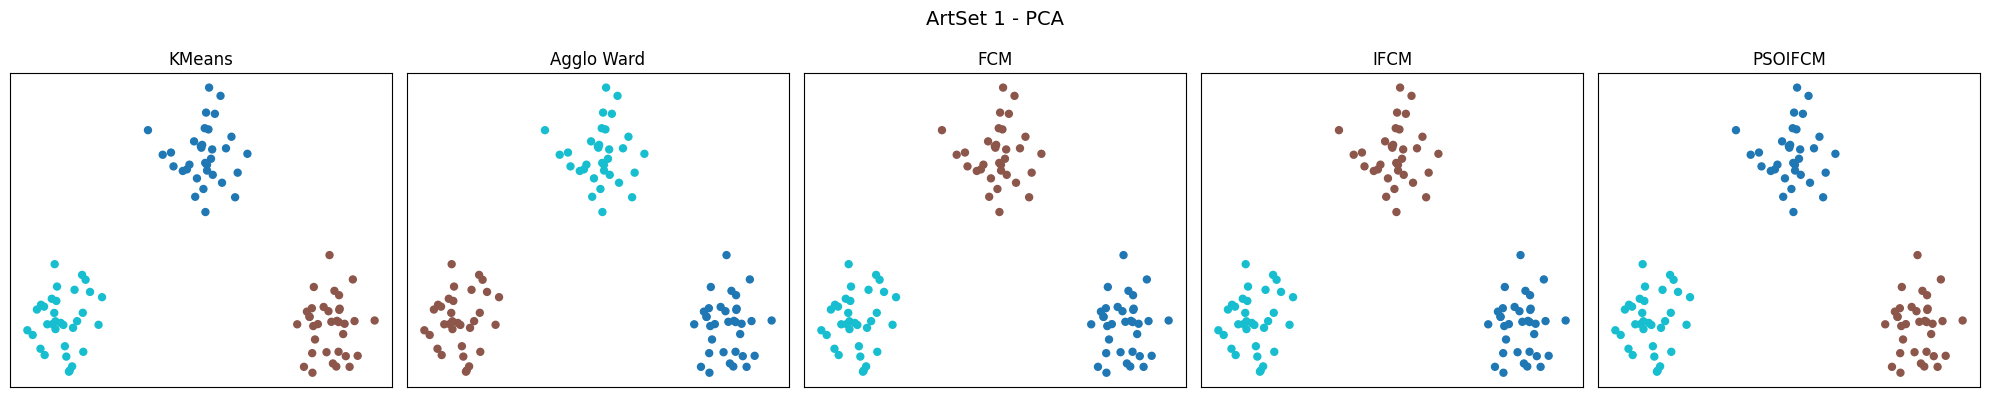


Dataset: ArtSet 2 (n=7, d=7, c=3)
KMeans                    | Acc = 1.000 | ICD = 3.012
Agglo Ward                | Acc = 1.000 | ICD = 3.012
FCM                       | Acc = 1.000 | ICD = 3.012
IFCM                      | Acc = 1.000 | ICD = 3.012
PSOIFCM                   | Acc = 1.000 | ICD = 3.012


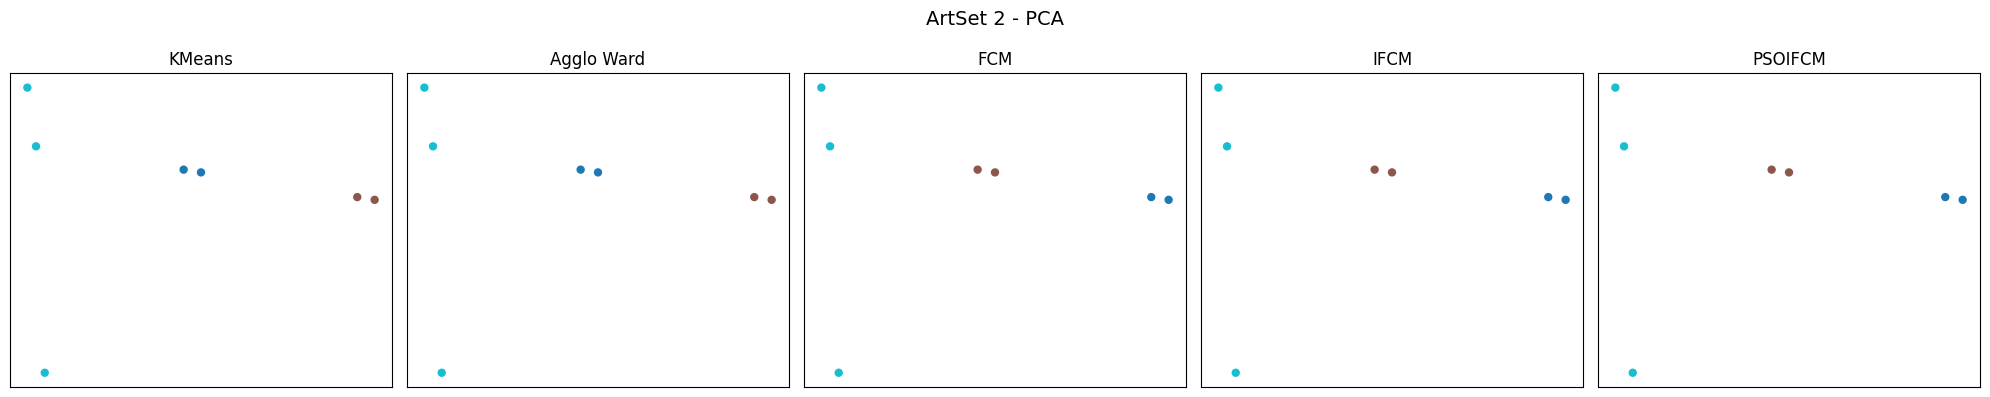


Dataset: ArtSet 3 (n=15, d=2, c=2)
KMeans                    | Acc = 1.000 | ICD = 4.482
Agglo Ward                | Acc = 1.000 | ICD = 4.482
FCM                       | Acc = 1.000 | ICD = 4.482
IFCM                      | Acc = 1.000 | ICD = 4.482
PSOIFCM                   | Acc = 1.000 | ICD = 4.482


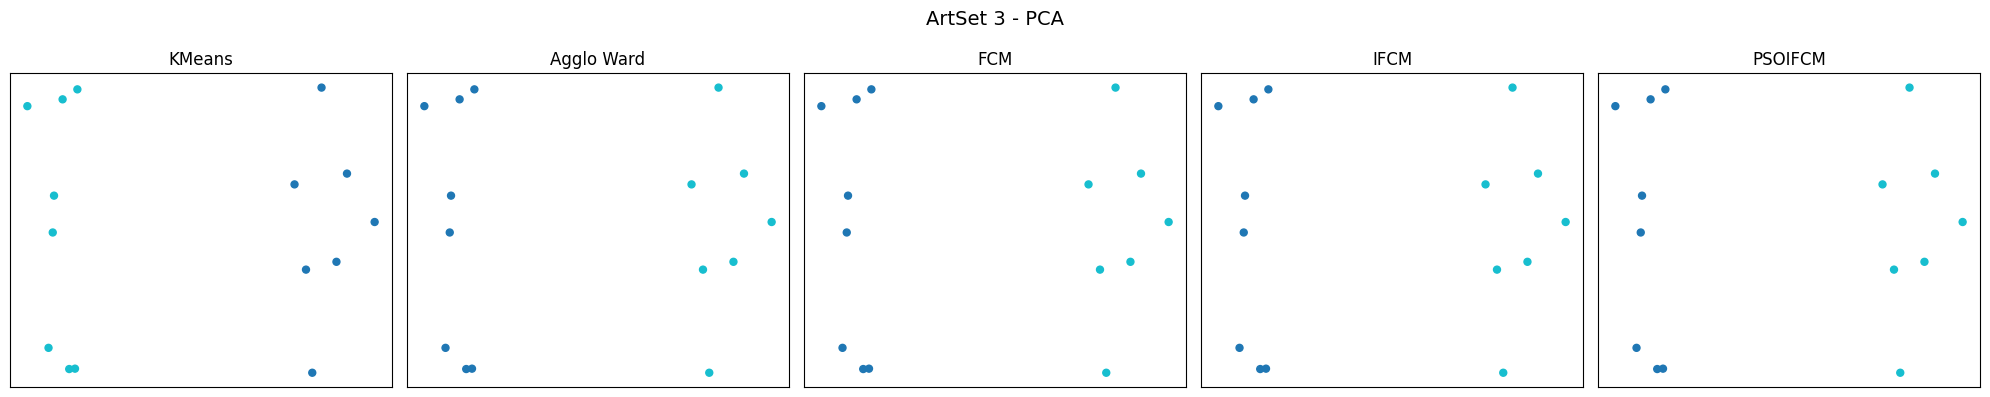

EXPERIMENTATIONS TERMINEES


In [18]:
# --------------------------------------------------------
# Fonction : evaluate_and_store
# --------------------------------------------------------
# Évalue un algorithme de clustering selon deux métriques :
# - précision (après permutation optimale des labels)
# - distance inter-clusters minimale (séparation)
# Les résultats sont affichés et stockés dans un dictionnaire global.
def evaluate_and_store(X, y_true, get_labels_fn, algo_name, results):
    """
    Évalue un algorithme de clustering et enregistre ses résultats.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        y_true (array-like): étiquettes réelles.
        get_labels_fn (callable): fonction retournant les labels prédits.
        algo_name (str): nom de l’algorithme testé.
        results (dict): dictionnaire de stockage des résultats.
    
    Returns:
        None
    """
    labels = get_labels_fn()
    acc = clustering_accuracy(y_true, labels)       # précision alignée
    icd = inter_cluster_distance(X, labels)         # séparation minimale
    print(f"{algo_name:25s} | Acc = {acc:.3f} | ICD = {icd:.3f}")
    
    # Stockage structuré
    results[algo_name] = {"labels": labels, "accuracy": acc, "icd": icd}


# --------------------------------------------------------
# Fonction : run_experiments_on_dataset
# --------------------------------------------------------
# Exécute tous les algorithmes de clustering sur un dataset donné :
# KMeans, Agglomeratif, FCM, IFCM et PSO-IFCM.
# Évalue chaque méthode, affiche les résultats et visualise les clusters.
def run_experiments_on_dataset(X, y, dataset_name, n_clusters):
    """
    Compare plusieurs algorithmes de clustering sur un même dataset.
    
    Args:
        X (ndarray): données (n_samples, n_features).
        y (array-like): étiquettes réelles.
        dataset_name (str): nom du dataset.
        n_clusters (int): nombre de clusters à trouver.
    
    Returns:
        dict: résultats agrégés par algorithme.
    """
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_name} (n={X.shape[0]}, d={X.shape[1]}, c={n_clusters})")
    print(f"{'='*60}")
    
    results = {}
    
    # --- KMeans ---
    km = KMeans(n_clusters=n_clusters, n_init=20, random_state=0)
    evaluate_and_store(X, y, lambda: km.fit_predict(X), "KMeans", results)
    
    # --- Clustering hiérarchique (Ward) ---
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    evaluate_and_store(X, y, lambda: agg.fit_predict(X), "Agglo Ward", results)
    
    # --- FCM classique ---
    _, _, labels_fcm = fcm_classic(X, n_clusters, m=2.0, random_state=0)
    evaluate_and_store(X, y, lambda: labels_fcm, "FCM", results)
    
    # --- IFCM ---
    _, _, labels_ifcm = ifcm(X, n_clusters, m=2.0, random_state=0)
    evaluate_and_store(X, y, lambda: labels_ifcm, "IFCM", results)
    
    # --- PSO-IFCM ---
    _, _, labels_psoifcm = pso_ifcm(
        X, n_clusters, m=2.0, n_particles=20,
        max_iter_pso=50, max_iter_ifcm=100, random_state=0
    )
    evaluate_and_store(X, y, lambda: labels_psoifcm, "PSOIFCM", results)
    
    # --- Visualisation PCA comparative ---
    labels_for_plot = {name: r["labels"] for name, r in results.items()}
    plot_clusters_pca(X, labels_for_plot, f"{dataset_name} - PCA")
    
    return results


# --------------------------------------------------------
# Fonction : run_all
# --------------------------------------------------------
# Lance la comparaison complète sur un ensemble de jeux de données :
# Iris, Wine, BSW, Cancer, Seed, Soybean, Glass, CMC, etc.
# Pour chaque dataset → appel à run_experiments_on_dataset.
def run_all():
    """
    Exécute les expériences sur tous les datasets listés.
    
    Returns:
        None
    """
    datasets = [
        ("Iris", lambda: (load_iris().data, load_iris().target)),
        ("Wine", lambda: (load_wine().data, load_wine().target)),
        ("BSW", load_bsw),
        ("Cancer", load_cancer),
        ("Seed", load_seed),
        ("Soybean", load_soybean),
        ("Glass", load_glass),
        ("CMC", load_cmc),
        ("Wine 4D", load_wine_4d),
        ("ArtSet 1", load_artset1),
        ("ArtSet 2", load_artset2),
        ("ArtSet 3", load_artset3),
    ]
    
    for name, loader in datasets:
        X, y = loader()
        n_clusters = len(np.unique(y))
        run_experiments_on_dataset(X, y, name, n_clusters)


# ============================================================
# Main
# ============================================================
# Point d’entrée du notebook : lance toutes les expériences et affiche un résumé.
if __name__ == "__main__":
    run_all()
    print("EXPERIMENTATIONS TERMINEES")

